In [62]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn import manifold, datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcess
%matplotlib inline

### Generate Data and Embed using IsoMap
We first take the standard swiss roll data and use the sklearn isomap routine to "obtain" the manifold. The original data is $X$ and the embedded data is $Y$.

In [3]:
# generate data in 3d
X, color = datasets.samples_generator.make_swiss_roll(n_samples=10000)

In [4]:
# use isomap to embed in 2d
n_neighbors = 10
Y = manifold.Isomap(n_neighbors, 2).fit_transform(X)

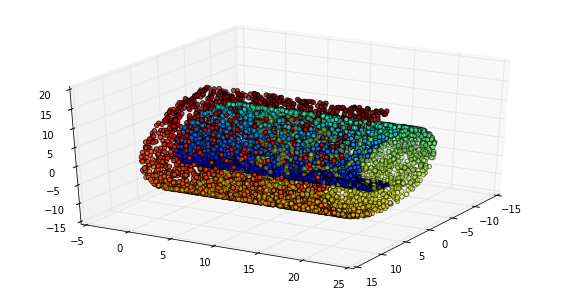

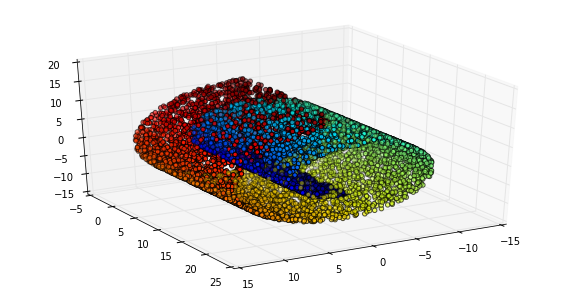

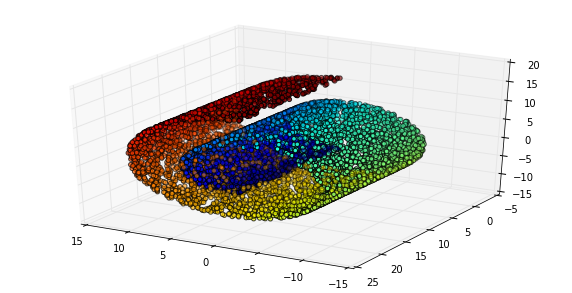

In [7]:
# plot raw data in 3d
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color)
ax.view_init(30, 30)
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color)
ax.view_init(30, 60)
plt.show()

fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], c=color)
ax.view_init(30, 120)
plt.show()


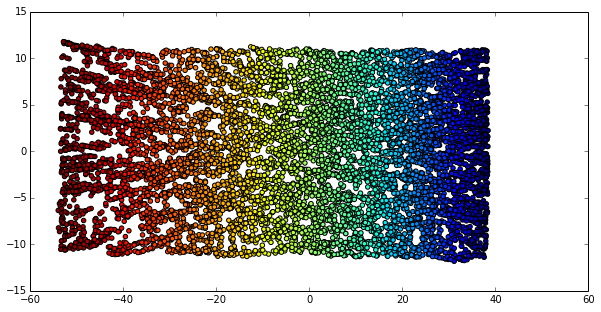

In [8]:
# plot isomap data in 2d
fig = plt.figure(figsize=(10,5))
plt.scatter(Y[:,0], Y[:,1], c=color)

#### Using a smaller sample of original data

In [13]:
rinds = np.random.permutation(X.shape[0])
Xsample = X[rinds[0:1000],:]
colorsample = color[rinds[0:1000]]
Xtest = X[rinds[1000:],:]
Yvalidate = Y[rinds[1000:]]
colorvalidate = color[rinds[1000:]]

In [14]:
# use isomap to embed the smaller sample in 2d
n_neighbors = 10
Ysample = manifold.Isomap(n_neighbors, 2).fit_transform(Xsample)

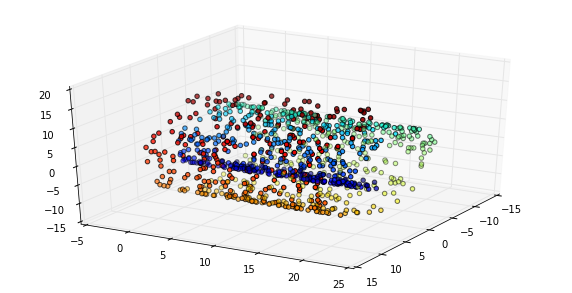

In [15]:
# show the sample data in 3d
fig = plt.figure(figsize=(10,5))
ax = fig.gca(projection='3d')
ax.scatter(Xsample[:,0], Xsample[:,1], Xsample[:,2], c=colorsample)
ax.view_init(30, 30)
plt.show()

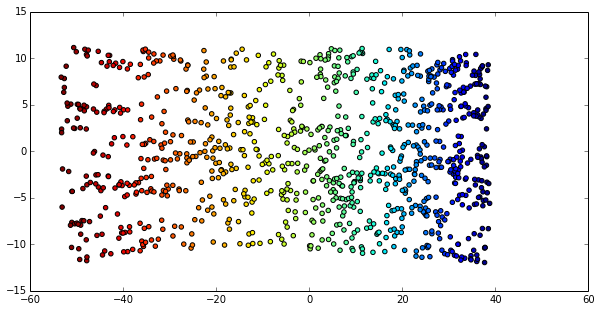

In [16]:
# plot sample isomap data in 2d
fig = plt.figure(figsize=(10,5))
plt.scatter(Ysample[:,0], Ysample[:,1], c=colorsample)

In [18]:
# correlation between the two embedded dimensions -- close to 0
np.corrcoef(np.transpose(Ysample))

array([[  1.00000000e+00,  -2.61400036e-18],
       [ -2.61400036e-18,   1.00000000e+00]])

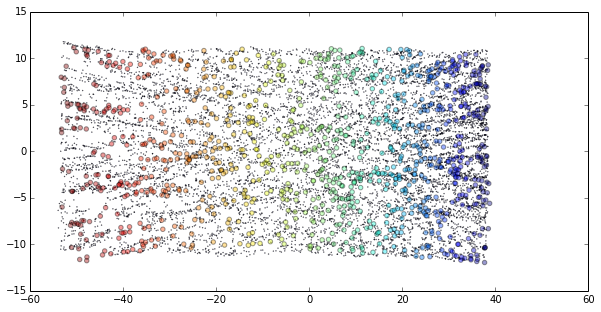

In [37]:
# show the embedded locations of the "remaining" points with respect to the sample points
fig = plt.figure(figsize=(10,5))
plt.scatter(Yvalidate[:,0], Yvalidate[:,1],s=0.1)
plt.scatter(Ysample[:,0], Ysample[:,1], c=colorsample,alpha=0.4)

### Learn a functional mapping from $X_{sample}$ to $Y_{sample}$
Note that the output is multi-dimensional (2 dimensions in this case). The plot above shows no correlation between the two dimensions, so we can learn independent functions to predict each dimension. However, in other scenarios, we might have to learn a "correlated" regression function. This is not terribly hard to do, using SVRs or Gaussian Process.

#### Support Vector Regression
Note that the parameter $\gamma$ for SVR (width of the Gaussian kernel) becomes important here. If $\gamma$ is set to high, points that are close in raw space but not on the manifold will start getting mapped to wrong regions. After trying varying values of $\gamma$, I settled on 0.005. Even that shows a little wierd behavior around the edges of the manifold. 

In [58]:
# embedded dimension 1
sv = SVR(gamma=0.005)
y = Ysample[:,0]
sv.fit(Xsample, y)
# Make the prediction
ypred1 = sv.predict(Xtest)

In [59]:
# embedded dimension 2
sv = SVR(gamma=0.005)
y = Ysample[:,1]
sv.fit(Xsample, y)
# Make the prediction
ypred2 = sv.predict(Xtest)

In [60]:
Ypred = np.transpose(np.vstack([ypred1,ypred2]))

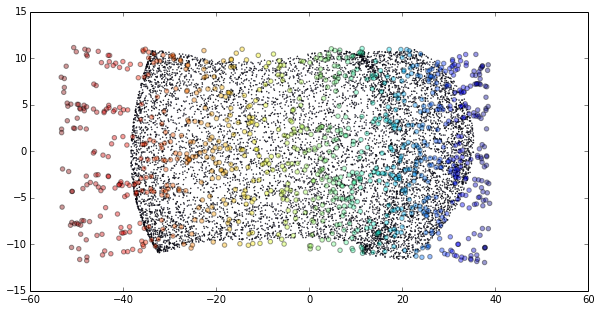

In [61]:
# plot the predicted values
fig = plt.figure(figsize=(10,5))
plt.scatter(Ypred[:,0], Ypred[:,1],s=0.2)
plt.scatter(Ysample[:,0], Ysample[:,1], c=colorsample,alpha=0.4)

#### Gaussian Process Regression
Works much better than SVR. Probably because of the non-parametric nature. 

In [77]:
# embedded dimension 1
gp = GaussianProcess(regr='constant',corr='squared_exponential',
                     theta0=1, nugget=0.01,random_start=100)
y = Ysample[:,0]
gp.fit(Xsample, y)
# Make the prediction
ypred1 = gp.predict(Xtest)

In [78]:
# embedded dimension 1
gp = GaussianProcess(regr='constant',corr='squared_exponential',
                     theta0=1, nugget=0.01, random_start=100)
y = Ysample[:,1]
gp.fit(Xsample, y)
# Make the prediction
ypred2 = gp.predict(Xtest)

In [79]:
Ypred = np.transpose(np.vstack([ypred1,ypred2]))

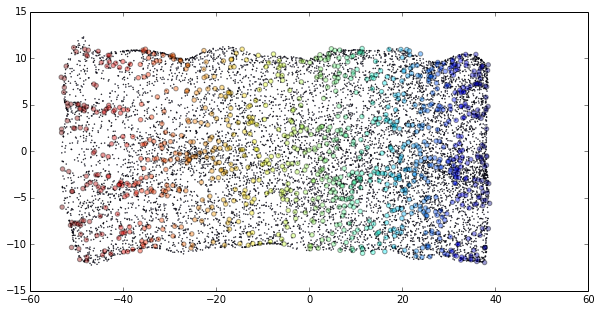

In [80]:
# plot the predicted values
fig = plt.figure(figsize=(10,5))
plt.scatter(Ypred[:,0], Ypred[:,1],s=0.2)
plt.scatter(Ysample[:,0], Ysample[:,1], c=colorsample,alpha=0.4)